## Negative Binomial VCM Results 

This notebook goes over the code needed to reproduce the results from the MSE and time figures for the Negative Binomial base distribution with Log Link and covariance matrix $\Gamma$ structured under variance component model framework as follows:

$$
\Gamma = \sigma_1 * \mathbf{1_{n} 1_{n}^\top}
$$

In this example simulate three fixed effects under our Quasi-Copula model with $\beta \sim$ randn(p) where p = 3 fixed effects.

We run each scenario 100 times and compare the fit of ours with that of GLMM's random intercept model from MixedModels.jl. 

In [1]:
versioninfo()

Julia Version 1.6.2
Commit 1b93d53fc4 (2021-07-14 15:36 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)


In [2]:
using GLMCopula, DelimitedFiles, LinearAlgebra, Random, GLM
using Random, Roots, SpecialFunctions, DataFrames

In [3]:
p  = 3    # number of fixed effects, including intercept
m  = 1    # number of variance components
# true parameter values
Random.seed!(1234)
βtrue = randn(p)
rtrue = 10
θtrue = [0.1]

# generate data
intervals = zeros(p + m, 2) #hold intervals
curcoverage = zeros(p + m) #hold current coverage resutls
trueparams = [βtrue; rtrue; θtrue] #hold true parameters

#simulation parameters
samplesizes = [100; 1000; 10000]
ns = [2; 5; 10; 15; 20; 25]
nsims = 100

100

In [4]:
@info "reading in the files with results"
βMseresult = vec(readdlm("mse_beta_multivariate_nb_vcm$(nsims)reps_sim.csv", ','))
θMseresult = vec(readdlm("mse_Sigma_multivariate_nb_vcm$(nsims)reps_sim.csv", ','))
fittimes_QC = vec(readdlm("fittimes_multivariate_nb_vcm$(nsims)reps_sim.csv", ','))

┌ Info: reading in the files with results
└ @ Main In[4]:1


1800-element Vector{Float64}:
   0.156487728
   0.175209342
   0.146498052
   0.123588563
   0.163731009
   0.169121774
 NaN
   0.096650705
   0.145765288
   0.146776947
   0.168334818
 NaN
   0.150398859
   ⋮
  14.57105758
  14.604639925
  15.259204839
  13.5320722
  13.844101082
  14.767020922
  15.462080272
  14.733132531
  12.350505118
  14.634767618
  15.006680761
  14.818074909

In [5]:
fittimes_GLMM = vec(readdlm("fittimes_GLMM_multivariate_NB_vcm$(nsims)reps_sim.csv", ','))

1800-element Vector{Float64}:
   0.316190126
   0.016436368
   0.017019368
   0.016128736
   0.015043076
   0.016748436
 NaN
   0.014266581
   0.015152926
   0.017052358
   0.016405912
 NaN
   0.016590481
   ⋮
  16.381802337
  16.906561464
  16.865890325
  15.291891692
  18.6822194
  18.909916886
  15.086475919
  17.2832781
  17.966309712
  17.024314953
  16.829654256
  17.073721341

In [6]:
#simulation parameters
@info "making results table Quasi-Copula"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes_QC)
timedf1 = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf1, Dict(:fittimes_function => "se"))
timedf1[!, :nobs] = Meta.parse.(timedf1[!, :samplesize]) .* Meta.parse.(timedf1[!, :obssize])
timedf1[!, :fitmin] = timedf1[!, :fittime] - timedf1[!, :se]
timedf1[!, :fitmax] = timedf1[!, :fittime] + timedf1[!, :se]
timedf1[!, :perobsratio] = timedf1[!, :fittime] ./ timedf1[!, :nobs]
timedf1

┌ Info: making results table Quasi-Copula
└ @ Main In[6]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,100,2,NaN,NaN,200,NaN,NaN,NaN
2,100,5,0.126362,0.00163346,500,0.124728,0.127995,0.000252724
3,100,10,0.135583,0.00201722,1000,0.133566,0.137601,0.000135583
4,100,15,0.162463,0.00329783,1500,0.159165,0.165761,0.000108309
5,100,20,0.163778,0.00234945,2000,0.161428,0.166127,8.18888e-5
6,100,25,0.178582,0.00200682,2500,0.176575,0.180589,7.14328e-5
7,1000,2,0.379602,0.00376731,2000,0.375835,0.38337,0.000189801
8,1000,5,0.676689,0.0468873,5000,0.629802,0.723576,0.000135338
9,1000,10,0.990534,0.0622005,10000,0.928334,1.05273,9.90534e-5


In [7]:
#simulation parameters
@info "making results table GLMM"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes_GLMM)
timedf2 = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf2, Dict(:fittimes_function => "se"))
timedf2[!, :nobs] = Meta.parse.(timedf2[!, :samplesize]) .* Meta.parse.(timedf2[!, :obssize])
timedf2[!, :fitmin] = timedf2[!, :fittime] - timedf2[!, :se]
timedf2[!, :fitmax] = timedf2[!, :fittime] + timedf2[!, :se]
timedf2[!, :perobsratio] = timedf2[!, :fittime] ./ timedf2[!, :nobs]
timedf2

┌ Info: making results table GLMM
└ @ Main In[7]:2


,samplesize,obssize,fittime,se,nobs,fitmin,fitmax,perobsratio
,String,String,Float64,Float64,Int64,Float64,Float64,Float64
1,100,2,NaN,NaN,200,NaN,NaN,NaN
2,100,5,0.0339996,0.000287964,500,0.0337116,0.0342875,6.79992e-5
3,100,10,0.0667958,0.000577671,1000,0.0662181,0.0673735,6.67958e-5
4,100,15,0.0997356,0.000908954,1500,0.0988266,0.100645,6.64904e-5
5,100,20,0.130851,0.00116639,2000,0.129684,0.132017,6.54254e-5
6,100,25,0.161888,0.00139845,2500,0.160489,0.163286,6.4755e-5
7,1000,2,0.166504,0.00123075,2000,0.165273,0.167735,8.32521e-5
8,1000,5,0.552018,0.0197297,5000,0.532288,0.571748,0.000110404
9,1000,10,1.06305,0.0344553,10000,1.02859,1.0975,0.000106305


┌ Warning: RCall.jl: Warning: package ‘ggplot2’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160
┌ Warning: RCall.jl: Warning: package ‘cowplot’ was built under R version 4.0.2
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160
┌ Warning: RCall.jl: Warning: Removed 1 row(s) containing missing values (geom_path).
│ Warning: Removed 1 rows containing missing values (geom_point).
│ Warning: Removed 1 row(s) containing missing values (geom_path).
│ Warning: Removed 1 rows containing missing values (geom_point).
└ @ RCall /Users/sarahji/.julia/packages/RCall/iMDW2/src/io.jl:160


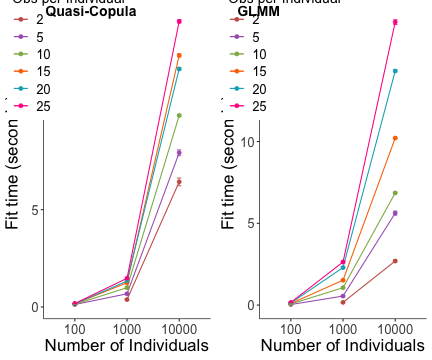

RObject{VecSxp}


In [8]:
########### plot the runtimes
using RCall
@rput timedf1
@rput timedf2
R"""
library(ggplot2)
library(cowplot)
timedf1$obssize = factor(timedf1$obssize, levels = c('2', '5', '10', '15', '20', '25'))
timedf1$samplesize = factor(timedf1$samplesize, levels = c('100', '1000', '10000'))

fittime_1 = ggplot(timedf1, aes(x = samplesize, y = fittime, group = obssize, color = obssize)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.15,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=13),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
   scale_color_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
  labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Obs per Individual")

timedf2$obssize = factor(timedf2$obssize, levels = c('2', '5', '10', '15', '20', '25'))
timedf2$samplesize = factor(timedf2$samplesize, levels = c('100', '1000', '10000'))

fittime_2 = ggplot(timedf2, aes(x = samplesize, y = fittime, group = obssize, color = obssize)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.15,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=13),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
   scale_color_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
  labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Obs per Individual")

fittime_nsamples = plot_grid(fittime_1, fittime_2, labels = c("Quasi-Copula", "GLMM"))
"""

In [11]:
R"""
ggsave('fittime_nsamples_nb_vs_glmm.png', fittime_nsamples, width = 12.5, height = 15, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "fittime_nsamples_nb_vs_glmm.png"


In [9]:
######  supplementary table s1
using Random, DataFrames, DelimitedFiles, Statistics
import StatsBase: sem

βθcoverage = readdlm("beta_r_sigma_coverage_multivariate_NB_vcm$(nsims)reps_sim.csv", ',')

m  = 1

covdf = DataFrame(Matrix(transpose(βΣcoverage)), :auto)
rename!(covdf, Symbol.([["β$i" for i in 1:p]; ["r"]; ["θ$i" for i in 1:m]]))
covdf[!, :samplesize] = sample_sizes
covdf[!, :obssize] = obs_sizes
first(covdf, 10)

row_stats = [[(mean(col), sem(col)) for col = eachcol(d[!, 1:end-2])] for d = groupby(covdf, [:samplesize; :obssize])]
df = DataFrame(row_stats, :auto)
ss_obs = unique("N: " .* sample_sizes .* "  ni: " .* obs_sizes)
rename!(df, Symbol.(ss_obs))
covdfdisplay = DataFrame([[names(df)]; collect.(eachrow(df))], 
    [:people_obs; Symbol.([["β$i" for i in 1:p];  ["r"];  ["θ$i" for i in 1:m]])])
# deletecols!(covdfdisplay, p + 2)
covdfdisplay


LoadError: UndefVarError: βΣcoverage not defined

In [12]:
#### 
#import data and reorganize to create figure
using Random, DataFrames, DelimitedFiles, Statistics, RCall, Printf
import StatsBase: sem

βMseresult = vec(readdlm("mse_beta_multivariate_NB_vcm$(nsims)reps_sim.csv", ','))
θMseresult = vec(readdlm("mse_Sigma_multivariate_NB_vcm$(nsims)reps_sim.csv", ','))
rMseresult =  vec(readdlm("mse_r_multivariate_NB_vcm$(nsims)reps_sim.csv", ','))

βMseresult_GLMM = vec(readdlm("mse_beta_GLMM_multivariate_NB_vcm$(nsims)reps_sim.csv", ','))
θMseresult_GLMM = vec(readdlm("mse_Sigma_GLMM_multivariate_NB_vcm$(nsims)reps_sim.csv", ','))
rMseresult_GLMM =  vec(readdlm("mse_r_GLMMmultivariate_NB_vcm$(nsims)reps_sim.csv", ','))


p = 3; m = 1
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))
msedf1 = DataFrame(βmse = βMseresult, thetamse = θMseresult, rmse = rMseresult,
    samplesize = sample_sizes, obssize = obs_sizes)

msedf2 = DataFrame(βmse = βMseresult_GLMM, thetamse = θMseresult_GLMM, rmse = rMseresult_GLMM,
    samplesize = sample_sizes, obssize = obs_sizes)

#rename to make parsing easier for R.

msedf1 = deepcopy(msedf1)
rename!(msedf1, ["betamse"
    "thetamse"
        "rmse"
    "samplesize"
 "obssize"]);

msedf2 = deepcopy(msedf2)
rename!(msedf2, ["betamse"
    "thetamse"
        "rmse"
    "samplesize"
 "obssize"]);

mses = [msedf1[!, :betamse]; msedf1[!, :thetamse];msedf1[!, :rmse]; msedf2[!, :betamse]; msedf2[!, :thetamse]; msedf2[!, :rmse]]
    # msedfnormR[!, :betamse]; msedfnormR[!, :taumse]; msedfnormR[!, :Sigmamse]]
obssize = [collect([repeat(msedf1[!, :obssize], 3)]...) ; collect([repeat(msedf2[!, :obssize], 3)]...)]
#40
samplesize = [collect([repeat(msedf1[!, :samplesize], 3)]...) ; collect([repeat(msedf2[!, :samplesize], 3)]...)]

parameters = [collect([repeat(string.([:beta, :theta, :r]), inner = nsims * length(ns) * length(samplesizes))]...) ; collect([repeat(string.([:beta, :theta, :r]), inner = nsims * length(ns) * length(samplesizes))]...)]
robust = [collect([repeat(["Negative Binomial QC"], 3 * nsims * length(ns) * length(samplesizes))]...); collect([repeat(["Negative Binomial GLMM"],  3 * nsims * length(ns) * length(samplesizes))]...)]

msedfR = DataFrame(mse = mses, obssize = obssize, samplesize = samplesize,
    parameters = parameters, robust = robust)

#5 of the 30,000 simulations did not converge, filter out
msedfR = filter(x -> !isnan(x.mse), msedfR)
# additionally, there are 5 where an error was not caught so it did not try a differnt solver
msedfR = filter(x -> x.mse < 40000, msedfR)

,mse,obssize,samplesize,parameters,robust
,Float64,String,String,String,String
1,0.0123026,2,100,beta,Negative Binomial QC
2,0.00349949,2,100,beta,Negative Binomial QC
3,0.00112207,2,100,beta,Negative Binomial QC
4,0.00129409,2,100,beta,Negative Binomial QC
5,0.00430889,2,100,beta,Negative Binomial QC
6,0.000850084,2,100,beta,Negative Binomial QC
7,0.000984275,2,100,beta,Negative Binomial QC
8,0.00648522,2,100,beta,Negative Binomial QC
9,0.00190804,2,100,beta,Negative Binomial QC


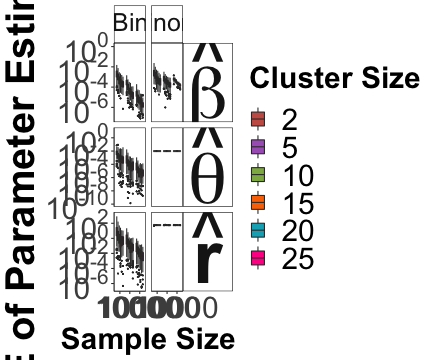

RObject{VecSxp}


In [16]:
### working on figure next
@rput msedfR

R"""
library(scales)
library(ggplot2)
library(data.table)

msedfR = data.table(msedfR)

msedfR[parameters == "beta",y_min := 10^-4]
msedfR[parameters == "beta",y_max := 10^0]
msedfR[parameters == "theta",y_min := 10^-4]
msedfR[parameters == "theta",y_max := 10^1]
msedfR[parameters == "r", y_min := 10^-3]
msedfR[parameters == "r", y_max := 10^3]

#msedfR[parameters == "beta",y_min := 10^-8]
#msedfR[parameters == "beta",y_max := 10^-2]
#msedfR[parameters == "tau",y_min := 10^-8]
#msedfR[parameters == "tau",y_max := 10^-2]
#msedfR[parameters == "Sigma",y_min := 10^-5]
#msedfR[parameters == "Sigma",y_max := 10^-2]


msedfR$obssize = factor(msedfR$obssize, levels = c('2', '5', '10', '15', '20', '25'))
msedfR$samplesize = factor(msedfR$samplesize, levels = c('100', '1000', '10000'))
msedfR$parameters = factor(msedfR$parameters, levels = c('beta', 'theta', 'r'), labels = c(beta = expression(hat(bold(beta))), theta = expression(hat(bold(theta))[]), r = expression(hat(bold(r))[])))
msedfR$robust <- factor(msedfR$robust, levels = c('Negative Binomial QC', 'Negative Binomial GLMM'),
    labels = c(expression(paste("Negative Binomial QC")), expression(paste("Negative Binomial GLMM"))))

#mseplot <- ggplot(msedfR[msedfR$mse < 10^0, ], aes(x=samplesize, y=mse, fill=obssize)) + 
mseplot = ggplot(msedfR[msedfR$mse < 10^3, ], aes(x=samplesize, y=mse, fill=obssize)) + 
  #geom_boxplot(outlier.size = 0.0, outlier.alpha = 0) +
  geom_boxplot(outlier.size = 0.25) +
#    geom_violin() +
    facet_grid(parameters ~ robust, labeller = label_parsed, scales = "free_y") +
  theme(legend.position="right", legend.key = element_blank(), axis.text.x = element_text(angle=0, size=30),
        axis.text.y = element_text(angle=0, size=30), axis.title.x = element_text(size = 30, face="bold"), 
        axis.title.y = element_text(size = 40, face="bold"), legend.title = element_text(size = 30, face="bold"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.text=element_text(size=30), panel.background = element_rect(fill = NA, color = "black"),
        #panel.background = element_blank(), #panel.border = element_blank(),
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5),
        strip.background = element_rect(colour="black", fill="white"), strip.text.y = element_text(angle = 0, size=75, face="bold"),
        strip.text.x = element_text(size=25)) + 
  scale_fill_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
#scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x)) +
#scale_y_log10(breaks = 10^(-8:8), limit=c(10^-8, 10^2)) + 
scale_y_log10(breaks = 10^seq(-10, 10, 2), labels=trans_format("log10", math_format(10^.x))) + #, limit=c(10^-8, 10^2)) +
  labs(x = "Sample Size", y = "MSE of Parameter Estimates", fill = "Cluster Size") +
geom_blank(aes(y = y_max)) + 
geom_blank(aes(y = y_min)) 

"""

In [18]:
R"""
ggsave('updated_msefacetplot_nb.png', mseplot, width = 13.5, height = 15, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "updated_msefacetplot_nb.png"
